# Introduction


Ocular Disease Recognition dataset

* Normal (N);  
* Diabetes (D);  
* Glaucoma (G);  
* Cataract (C);  
* AMD (A);  
* Hypertension (H);  
* Myopia (M);
* Other diseases/abnormalities (O)  


This project focuses on Cataract.


# Data Preprocessing

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 50
NUM_CLASSES = 2
DATA_FOLDER = "/content/drive/MyDrive/Ocular Disease Recognition/ODIR-5K/Training Images"
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2 as cv
from random import shuffle
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
# import tensorflow_addons as tfa
import tensorflow as tf
%matplotlib inline

In [22]:
data_df = pd.read_excel(open("/content/drive/MyDrive/Ocular Disease Recognition/ODIR-5K/data.xlsx", 'rb'), sheet_name='Sheet1')

In [23]:
data_df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]

In [24]:
data_df

,id,age,sex,left_fundus,right_fundus,left_diagnosys,right_diagnosys,normal,diabetes,glaucoma,cataract,amd,hypertension,myopia,other
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


In [18]:
path = '/content/drive/MyDrive/Ocular Disease Recognition/preprocessed_images/'

In [25]:
data_df['left_fundus'][0]

'0_left.jpg'

In [26]:
path+data_df['left_fundus'][0]

'/content/drive/MyDrive/Ocular Disease Recognition/preprocessed_images/0_left.jpg'

In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt

img = tf.keras.preprocessing.image.load_img(path+data_df['left_fundus'][0])
img_array = tf.keras.preprocessing.image.img_to_array(img)

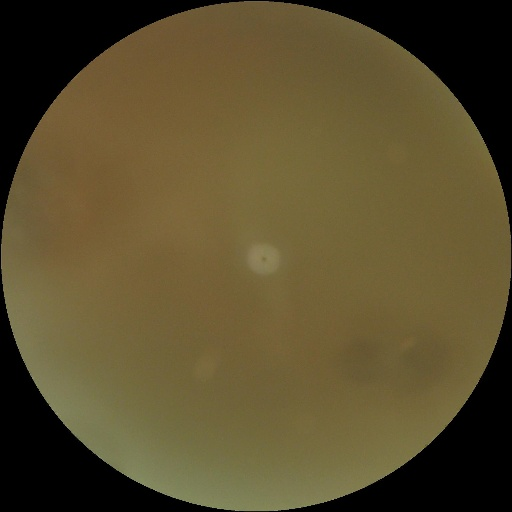

In [28]:
img

In [30]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

path = '/content/drive/MyDrive/Ocular Disease Recognition/preprocessed_images/'
metadata_df = data_df

def load_and_organize_data(image_path, metadata_df):
    image_data = []
    labels = []

    for index, row in metadata_df.iterrows():
        left_image_path = os.path.join(image_path, row['left_fundus'])
        right_image_path = os.path.join(image_path, row['right_fundus'])
        if os.path.exists(left_image_path) and os.path.exists(right_image_path):

            left_img = tf.keras.preprocessing.image.load_img(left_image_path, target_size=(224, 224))
            right_img = tf.keras.preprocessing.image.load_img(right_image_path, target_size=(224, 224))

            left_img_array = tf.keras.preprocessing.image.img_to_array(left_img) / 255.0
            right_img_array = tf.keras.preprocessing.image.img_to_array(right_img) / 255.0

            combined_image = np.concatenate((left_img_array, right_img_array), axis=2)

            image_data.append(combined_image)

            labels.append([row['normal'], row['diabetes'], row['glaucoma'], row['cataract'],
                           row['amd'], row['hypertension'], row['myopia'], row['other']])

    image_data = np.array(image_data)
    labels = np.array(labels)

    return image_data, labels


In [40]:

X_images, y_labels = load_and_organize_data(path, metadata_df.iloc[:1000,:])

print("Images shape:", X_images.shape)  # Expected: (num_samples, 224, 224, 6)
print("Labels shape:", y_labels.shape)  # Expected: (num_samples, 8)


Images shape: (792, 224, 224, 6)
Labels shape: (792, 8)


In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_images, y_labels, test_size=0.2, random_state=42)

# CNN model for multi-label classification
def create_multilabel_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))  # Sigmoid for multi-label output

    return model

input_shape = (224, 224, 6)  # 224x224 pixels, 6 channels (3 for left and 3 for right images)
num_classes = y_labels.shape[1]  # 8 labels for multi-label classification

model = create_multilabel_cnn(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 16
epochs = 25

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.4105 - loss: 0.4265 - val_accuracy: 0.3774 - val_loss: 0.3156
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4001 - loss: 0.3260 - val_accuracy: 0.3774 - val_loss: 0.3043
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4090 - loss: 0.3209 - val_accuracy: 0.3774 - val_loss: 0.3018
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4034 - loss: 0.3146 - val_accuracy: 0.3774 - val_loss: 0.3039
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4334 - loss: 0.3075 - val_accuracy: 0.3774 - val_loss: 0.3061
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4059 - loss: 0.3149 - val_accuracy: 0.3774 - val_loss: 0.3017
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4309 - loss: 0.2904 - val_accuracy: 0.3774 - val_loss: 0.2967
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4188 - loss: 0.2938 - val_accuracy: 0.3774 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


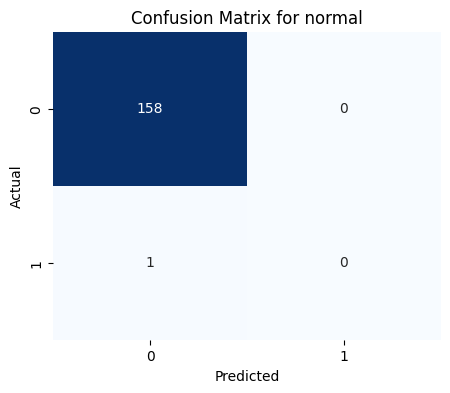

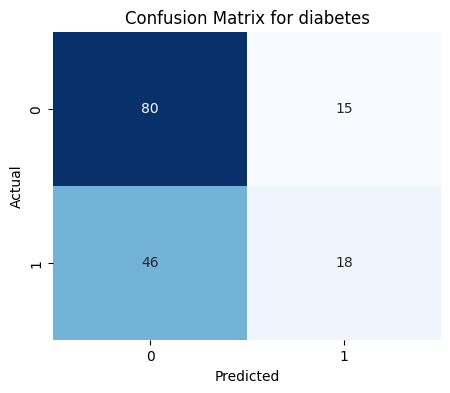

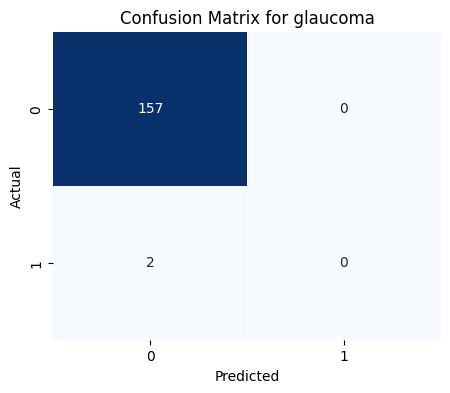

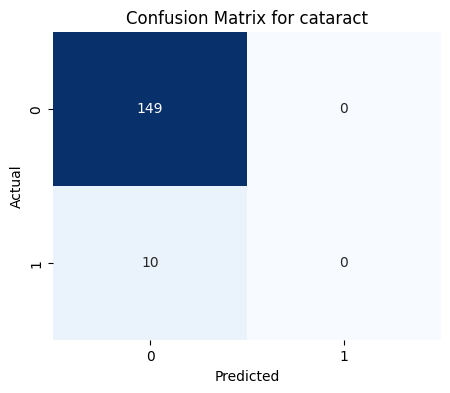

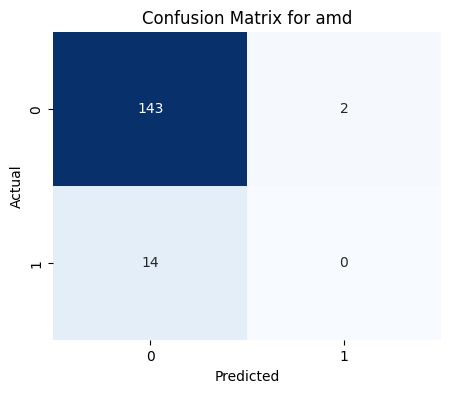

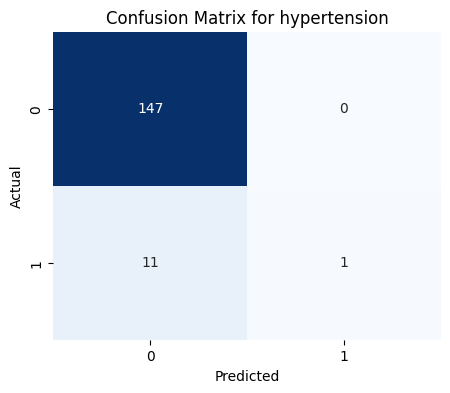

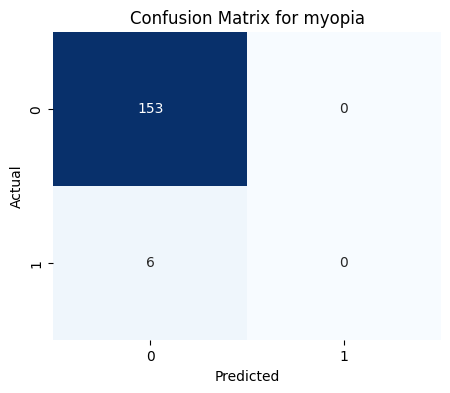

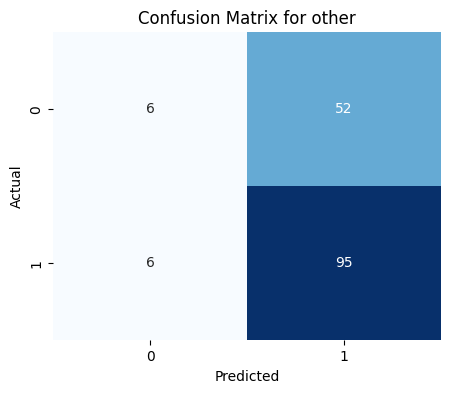

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = model.predict(X_val)

threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

labels = ["normal", "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]

for i, label in enumerate(labels):
    cm = confusion_matrix(y_val[:, i], y_pred[:, i])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {label}")
    plt.show()
